# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib
import requests
import sqlite3

# Extracting Item IDs from the Database

In [ ]:
# get items ids from db
db_path = 'prod.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT item_id FROM items")
item_ids = cursor.fetchall()

item_ids = [item[0] for item in item_ids]
df_item_ids = pd.DataFrame(item_ids, columns=['item_id'])

df_item_ids.to_csv('item_ids.csv', index=False)

conn.close()

print("Item IDs have been saved to 'item_ids.csv'")

Item IDs have been saved to 'item_ids.csv'


# Clustering

In [ ]:
import pandas as pd

item_df = pd.read_csv("item_ids.csv")
item_ids = item_df["item_id"].tolist()

In [ ]:
import requests
import pandas as pd
import numpy as np

def get_price_series(item_id):
    url = f"https://api.weirdgloop.org/exchange/history/rs/all?id={item_id}"
    try:
        response = requests.get(url)
        data = response.json()
        if str(item_id) in data:
            df = pd.DataFrame(data[str(item_id)])
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
            df = df.sort_values("timestamp").reset_index(drop=True)
            return df["price"].values
        else:
            return None
    except:
        return None

In [ ]:
def preprocess_series(series, length=100):
    series = series[-length:]
    if len(series) < length:
        pad = [series[-1]] * (length - len(series))
        series = np.concatenate([pad, series])
    return series

In [ ]:
import pandas as pd
import requests
import csv
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

item_ids_df = pd.read_csv("item_ids.csv")
item_ids = item_ids_df["item_id"].tolist()

output_file = "price_features.csv"
failed_items = []

if not os.path.exists(output_file):
    with open(output_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["item_id"] + [f"diff_{i}" for i in range(50)])

scaler = StandardScaler()

for i, item_id in tqdm(enumerate(item_ids), total=len(item_ids)):
    try:
        response = requests.get(f"https://api.weirdgloop.org/exchange/history/rs/all?id={item_id}")

        if response.status_code != 200:
            failed_items.append(item_id)
            continue

        data = response.json()

        if str(item_id) not in data or not data[str(item_id)]:
            failed_items.append(item_id)
            continue

        df = pd.DataFrame(data[str(item_id)])
        df["price_diff"] = df["price"].diff()
        features = df["price_diff"].dropna().tail(50).values

        if len(features) == 50:
            normalized_features = scaler.fit_transform(features.reshape(-1, 1)).flatten()

            with open(output_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([item_id] + list(normalized_features))
        else:
            failed_items.append(item_id)

    except Exception as e:
        failed_items.append(item_id)

pd.DataFrame(failed_items, columns=["failed_item_id"]).to_csv("failed_items.csv", index=False)

100%|██████████| 6848/6848 [2:27:45<00:00,  1.29s/it]


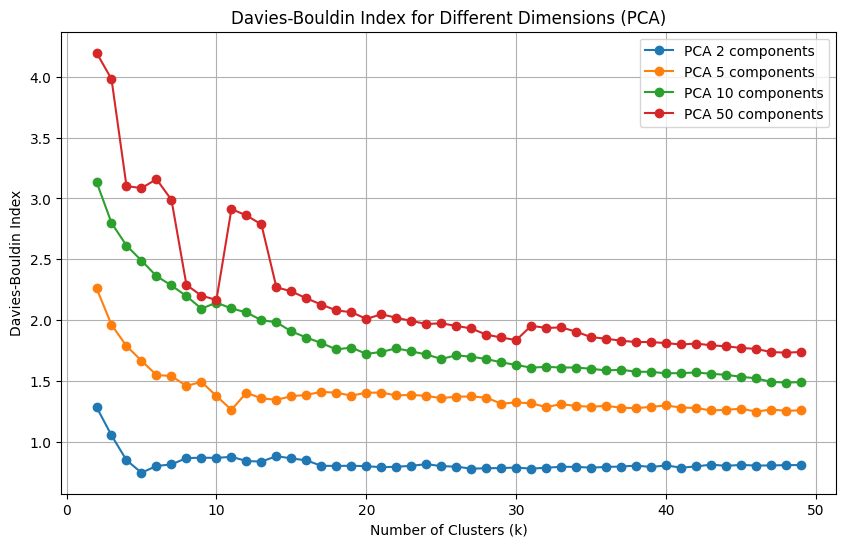

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Load the feature data
features_df = pd.read_csv("price_features.csv")
valid_ids = features_df["item_id"].tolist()
X = features_df.drop(columns=["item_id"]).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize a range of components for PCA
components_range = [2, 5, 10, 50]
K_range = range(2, 50)

# Set up a plot
plt.figure(figsize=(10, 6))

# Loop over different dimensions to apply PCA
for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)

    db_scores = []

    # Calculate Davies-Bouldin Index for each k
    '''
    Lower DBI indicates better clustering.
    The DBI measures how well-separated the clusters are,
    with lower values signifying that clusters are less dispersed and more distinct.
    '''
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_reduced)
        score = davies_bouldin_score(X_reduced, kmeans.labels_)
        db_scores.append(score)

    # Plot the DBI for this number of components
    plt.plot(K_range, db_scores, marker='o', label=f'PCA {n_components} components')

# Add labels and title
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index for Different Dimensions (PCA)")
plt.legend()
plt.grid(True)
plt.show()

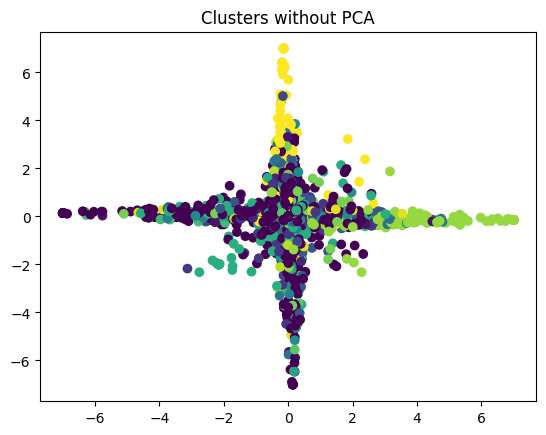

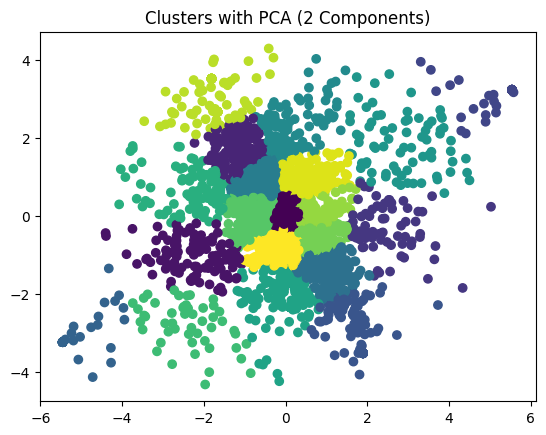

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Without PCA (original data)
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(X)  # X is the original feature matrix
labels = kmeans.labels_

# Visualize clusters
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("Clusters without PCA")
plt.show()

# With PCA (dimensionality reduction)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans_pca = KMeans(n_clusters=20, random_state=42)
kmeans_pca.fit(X_pca)
labels_pca = kmeans_pca.labels_

# Visualize clusters after PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca)
plt.title("Clusters with PCA (2 Components)")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Perform KMeans clustering on the reduced data
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Save the cluster labels and item IDs into a new DataFrame
cluster_map = pd.DataFrame({"item_id": valid_ids, "cluster": labels})

# Count the number of items in each cluster
cluster_counts = cluster_map['cluster'].value_counts().sort_index()
print("Number of items in each cluster:")
print(cluster_counts)

# Step 5: Save the cluster mapping to a CSV
cluster_map.to_csv("item_cluster_map.csv", index=False)

Number of items in each cluster:
cluster
0     3005
1      113
2      178
3      108
4       51
5      119
6       39
7      309
8      337
9      176
10      77
11     190
12     133
13      50
14     549
15     353
16     296
17     132
18     221
19     384
Name: count, dtype: int64


# Training and Testing Models Per Cluster

In [1]:
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import numpy as np
import os

# Load the item_cluster_map.csv (this contains item_id and their respective cluster)
cluster_map_df = pd.read_csv('item_cluster_map.csv')

# Create a dictionary to group items by their respective clusters
clustered_items = defaultdict(list)

# Group item_ids by cluster
for index, row in cluster_map_df.iterrows():
    item_id = row['item_id']
    cluster = row['cluster']
    clustered_items[cluster].append(item_id)

# Load price_features.csv (this contains item_id and price diffs)
price_features_df = pd.read_csv('price_features.csv')

# Drop items where all diffs are 0 (cleaning data)
price_features_df = price_features_df.loc[
    (price_features_df.iloc[:, 1:] != 0).any(axis=1)
]

# Function to get price diffs for items in a cluster
def get_price_diffs_for_cluster(clustered_items, price_features_df):
    cluster_price_diffs = {}

    for cluster, item_ids in clustered_items.items():
        # Filter price features for the current cluster
        cluster_df = price_features_df[price_features_df['item_id'].isin(item_ids)]
        # Drop the item_id column and store the rest of the price diff columns
        cluster_price_diffs[cluster] = cluster_df.drop(columns=["item_id"]).values

    return cluster_price_diffs

# Get price diffs for all clusters
cluster_price_diffs = get_price_diffs_for_cluster(clustered_items, price_features_df)

# ensure models folder exists
os.makedirs("models", exist_ok=True)

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib
import pandas as pd
import numpy as np

# Initialize models dictionary for each cluster
cluster_models = {}

# For each cluster, train, test, and evaluate the XGBoost model
for cluster, cluster_data in cluster_price_diffs.items():
    # Convert the numpy array (cluster_price_diffs) to a DataFrame for easier handling
    cluster_df = pd.DataFrame(cluster_data, columns=[f"diff_{i}" for i in range(cluster_data.shape[1])])

    # Add statistical features (mean, std, etc.)
    cluster_df['mean'] = cluster_df.mean(axis=1)
    cluster_df['std'] = cluster_df.std(axis=1)
    cluster_df['max'] = cluster_df.max(axis=1)
    cluster_df['min'] = cluster_df.min(axis=1)
    cluster_df['range'] = cluster_df['max'] - cluster_df['min']
    cluster_df['median'] = cluster_df.median(axis=1)

    # Add time-based features
    # 1. Lag features (previous 3 time steps)
    for i in range(1, 4):
        cluster_df[f'lag_{i}'] = cluster_df['diff_0'].shift(i)

    # 2. Rolling mean (window size of 3)
    cluster_df['rolling_mean'] = cluster_df['diff_0'].rolling(window=3).mean()

    # 3. Difference from previous time step
    cluster_df['diff_from_previous'] = cluster_df['diff_0'].diff().fillna(0)

    # 4. Cumulative sum (helps to understand the overall trend)
    cluster_df['cumulative_sum'] = cluster_df['diff_0'].cumsum()

    # 5. Exponential Moving Average (EMA)
    cluster_df['ema'] = cluster_df['diff_0'].ewm(span=3, adjust=False).mean()

    # 6. Rolling Statistics for Larger Windows
    # cluster_df['rolling_mean_5'] = cluster_df['diff_0'].rolling(window=5).mean()
    # cluster_df['rolling_std_5'] = cluster_df['diff_0'].rolling(window=5).std()

    # 7. Log Transformation (for normalization of skewed data)
    cluster_df['log_diff_0'] = np.log1p(cluster_df['diff_0'].clip(lower=0))

    # 8. Smoothed Price (5-step rolling mean)
    cluster_df['smoothed_diff'] = cluster_df['diff_0'].rolling(window=5).mean().fillna(0)

    # 9. Absolute difference between max and min
    cluster_df['abs_max_min_diff'] = (cluster_df['max'] - cluster_df['min']).abs()

    # 10. Percentile Features
    cluster_df['percentile_25'] = cluster_df['diff_0'].apply(lambda x: np.percentile(x, 25))
    cluster_df['percentile_50'] = cluster_df['diff_0'].apply(lambda x: np.percentile(x, 50))
    cluster_df['percentile_75'] = cluster_df['diff_0'].apply(lambda x: np.percentile(x, 75))

    # Define features (X) and target (y)
    X = cluster_df.dropna(axis=0).iloc[:, 1:]  # Remove any rows with NaN values (after shift/rolling operations)
    y = cluster_df.dropna(axis=0).iloc[:, 0]   # The first column (diff_0) as the target

    # Split data into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize DMatrix (used by xgb.train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set up parameters
    params = {
        'learning_rate': 0.05,
        'max_depth': 10,
        'min_child_weight': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'alpha': 0.5,
        'lambda': 1,
        'objective': 'reg:squarederror'
    }

    # Set up evaluation list
    evallist = [(dtest, 'eval'), (dtrain, 'train')]

    # Train the model with early stopping
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=evallist,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predictions on the test set using the trained model
    y_pred = model.predict(dtest)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Cluster {cluster} - MAE: {mae:.4f}, R²: {r2:.4f}")

    # Save the trained model for the current cluster
    cluster_models[cluster] = model
    joblib.dump(model, f"models/model_cluster_{cluster}.pkl")

Cluster 2 - MAE: 0.0853, R²: 0.9613
Cluster 0 - MAE: 0.0440, R²: 0.9511
Cluster 16 - MAE: 0.0886, R²: 0.7916
Cluster 10 - MAE: 0.3308, R²: 0.6319
Cluster 15 - MAE: 0.0630, R²: 0.9653
Cluster 19 - MAE: 0.0684, R²: 0.9710
Cluster 14 - MAE: 0.0155, R²: 0.9938
Cluster 8 - MAE: 0.0452, R²: 0.9980
Cluster 7 - MAE: 0.0596, R²: 0.9969
Cluster 18 - MAE: 0.0497, R²: 0.9721
Cluster 11 - MAE: 0.0615, R²: 0.9545
Cluster 9 - MAE: 0.1008, R²: 0.9716
Cluster 17 - MAE: 0.1308, R²: 0.8278
Cluster 12 - MAE: 0.1290, R²: 0.8636
Cluster 1 - MAE: 0.1360, R²: 0.9224
Cluster 5 - MAE: 0.2209, R²: 0.7703
Cluster 3 - MAE: 0.1906, R²: 0.8064
Cluster 6 - MAE: 0.2742, R²: -0.0083
Cluster 4 - MAE: 0.0470, R²: -0.0524
Cluster 13 - MAE: 0.1108, R²: 0.9506


In [3]:
!zip -r /content/models.zip /content/models
from google.colab import files
files.download('/content/models.zip')

  adding: content/models/ (stored 0%)
  adding: content/models/model_cluster_4.pkl (deflated 94%)
  adding: content/models/model_cluster_14.pkl (deflated 86%)
  adding: content/models/model_cluster_2.pkl (deflated 88%)
  adding: content/models/model_cluster_5.pkl (deflated 91%)
  adding: content/models/model_cluster_18.pkl (deflated 87%)
  adding: content/models/model_cluster_17.pkl (deflated 90%)
  adding: content/models/model_cluster_0.pkl (deflated 86%)
  adding: content/models/model_cluster_1.pkl (deflated 88%)
  adding: content/models/model_cluster_11.pkl (deflated 88%)
  adding: content/models/model_cluster_12.pkl (deflated 89%)
  adding: content/models/model_cluster_8.pkl (deflated 86%)
  adding: content/models/model_cluster_16.pkl (deflated 88%)
  adding: content/models/model_cluster_7.pkl (deflated 86%)
  adding: content/models/model_cluster_6.pkl (deflated 92%)
  adding: content/models/model_cluster_9.pkl (deflated 87%)
  adding: content/models/model_cluster_19.pkl (deflated 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>